<a href="https://colab.research.google.com/github/arthurbabey/deep_learning/blob/master/project_1/conv_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline
#import dlc_practical_prologue as prolog

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive')
import dlc_practical_prologue as prolog

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def nb_errors(pred, truth):
    
    pred_class = pred.argmax(1)
    return (pred_class - truth != 0).sum().item()

    
def train_model(model, train_input, train_target, test_input, test_target,  epochs=500, batch_size=100, lr=0.1):

    torch.nn.init.xavier_uniform_(model.conv1.weight)
    torch.nn.init.xavier_uniform_(model.conv2.weight)
    
    optimizer = torch.optim.Adam(model.parameters())
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    best_epoch = 0
    
    for i in range(epochs):
        model.train()
      
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(output, train_target.narrow(0, b, batch_size))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

        output_train = model(train_input)
        model.eval()
        output_test = model(test_input)
        train_loss.append(criterion(output_train, train_target).item())
        test_loss.append(criterion(output_test, test_target).item())
        accuracy = 1 - nb_errors(output_test, test_target) / 1000
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = i+1
        test_accuracy.append(accuracy)
        
        if i%100 == 0:
            print('Epoch : ',i+1, '\t', 'test loss :', test_loss[-1], '\t', 'train loss', train_loss[-1])
        
    return train_loss, test_loss, test_accuracy, best_accuracy


def nb_errors_10(pred, truth):
    
    pred_class = pred.view(-1, 2, 10).argmax(2).argmax(1)
    return (pred_class - truth != 0).sum().item()


def train_model_10(model, train_input, train_classes, test_input, test_target, test_classes,\
                epochs=250, batch_size=100, lr=0.1):
    
    torch.nn.init.xavier_uniform_(model.conv1.weight)
    torch.nn.init.xavier_uniform_(model.conv2.weight)
        
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    best_epoch = 0
    
    for i in range(epochs):
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            criterion = torch.nn.CrossEntropyLoss()
            labels = train_classes.narrow(0, b, batch_size)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        output_train = model(train_input)
        output_test = model(test_input)
        train_loss.append(criterion(output_train, train_classes).item())
        test_loss.append(criterion(output_test, test_classes).item())
        accuracy = 1 - nb_errors_10(output_test, test_target) / 1000
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = i+1
        test_accuracy.append(accuracy)

        #if i%100 == 0:
            #print('Epoch : ',i+1, '\t', 'test loss :', test_loss[-1], '\t', 'train loss', train_loss[-1])
       
    return train_loss, test_loss, test_accuracy, best_accuracy, best_epoch

### Direct approch with 2 dim output

In [0]:
class BaseLine(nn.Module):
    def __init__(self, nb_hidden = 50):
        super(BaseLine, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_1(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=2)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


class ConvNet_2(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 8, kernel_size=2)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 128)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_3(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 256)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_4(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 32, kernel_size=2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
baseline = BaseLine()

model_1_0 = ConvNet_1(50)
model_1_1 = ConvNet_1(100)
model_1_2 = ConvNet_1(250)
model_1_3 = ConvNet_1(1000)


model_2_0 = ConvNet_2(50)
model_2_1 = ConvNet_2(100)
model_2_2 = ConvNet_2(250)
model_2_3 = ConvNet_2(1000)


model_3_0 = ConvNet_3(50)
model_3_1 = ConvNet_3(100)
model_3_2 = ConvNet_3(250)
model_3_3 = ConvNet_3(1000)


model_4_0 = ConvNet_4(50)
model_4_1 = ConvNet_4(100)
model_4_2 = ConvNet_4(250)
model_4_3 = ConvNet_4(1000)


print(count_parameters(baseline),
count_parameters(model_1_0),
count_parameters(model_2_0),
count_parameters(model_3_0),
count_parameters(model_4_0))


models = [baseline, model_1_0,model_1_1, model_1_2, model_1_3,
          model_2_0,model_2_1, model_2_2, model_2_3,
          model_3_0,model_3_1, model_3_2, model_3_3,
          model_4_0,model_4_1, model_4_2, model_4_3]


if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

for model in models:
    model.to(device)

1924 3660 7680 17256 42552
Running on the GPU


In [0]:
import time

start = time.time()
epochs = 200
accuracies = torch.empty(17, 4, dtype=torch.float)

for i in range(4):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)
    train_input = train_input.cuda()
    train_target = train_target.cuda()
    test_input = test_input.cuda()
    test_target = test_target.cuda()

    for j in range(17):
        _, _, _, best_accuracy = train_model(models[j], train_input, train_target, test_input,\
                                             test_target, epochs=epochs, lr = 0.08)
        print('Model', j , best_accuracy)
        accuracies[j][i] = best_accuracy


minute = (time.time()-start) / 60
print('It took', minute, 'minutes.')

Epoch :  1 	 test loss : 6.2853312492370605 	 train loss 13.503097534179688
Epoch :  101 	 test loss : 0.6586242914199829 	 train loss 0.6643292307853699
Model 0 0.6739999999999999
Epoch :  1 	 test loss : 3.8688979148864746 	 train loss 7.858476638793945
Epoch :  101 	 test loss : 0.6413178443908691 	 train loss 0.6414110660552979
Model 1 0.73
Epoch :  1 	 test loss : 2.9207763671875 	 train loss 6.786711692810059
Epoch :  101 	 test loss : 0.6381037831306458 	 train loss 0.6427411437034607
Model 2 0.726
Epoch :  1 	 test loss : 2.358273506164551 	 train loss 13.141362190246582
Epoch :  101 	 test loss : 0.5760365128517151 	 train loss 0.619005024433136
Model 3 0.773
Epoch :  1 	 test loss : 3.1755950450897217 	 train loss 5.869510650634766
Epoch :  101 	 test loss : 0.5555346608161926 	 train loss 0.5107285380363464
Model 4 0.757
Epoch :  1 	 test loss : 1.2428226470947266 	 train loss 2.9529402256011963
Epoch :  101 	 test loss : 0.4755379855632782 	 train loss 0.47001850605010986
M

In [0]:
accuracies.mean(1)

tensor([0.6963, 0.7380, 0.7445, 0.7495, 0.7368, 0.7813, 0.7790, 0.7890, 0.7955,
        0.7375, 0.8088, 0.8118, 0.8165, 0.8178, 0.8200, 0.8200, 0.8230])

In [0]:
accuracies.std(1)

tensor([0.0244, 0.0058, 0.0197, 0.0159, 0.0221, 0.0105, 0.0143, 0.0133, 0.0154,
        0.1426, 0.0274, 0.0169, 0.0054, 0.0192, 0.0169, 0.0176, 0.0147])

Model with bigger amount of parameters seems to work better, let's try with even more trainable parameters

In [0]:
class bigConvNet_1(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 64, kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*128)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class bigConvNet_2(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 64, kernel_size=2)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*256)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class bigConvNet_3(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 100, kernel_size=2)
        self.conv2 = nn.Conv2d(100, 200, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*200, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*200)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


class bigConvNet_4(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels = 128, kernel_size=2)
        self.conv2 = nn.Conv2d(128, 1024, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*1024, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*1024)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
baseline = BaseLine()

model_1_0 = bigConvNet_1(50)
model_1_1 = bigConvNet_1(100)
model_1_2 = bigConvNet_1(500)
model_1_3 = bigConvNet_1(1000)


model_2_0 = bigConvNet_2(50)
model_2_1 = bigConvNet_2(100)
model_2_2 = bigConvNet_2(500)
model_2_3 = bigConvNet_2(1000)


model_3_0 = bigConvNet_3(50)
model_3_1 = bigConvNet_3(100)
model_3_2 = bigConvNet_3(500)
model_3_3 = bigConvNet_3(1000)



model_4_0 = bigConvNet_4(50)
model_4_1 = bigConvNet_4(100)
model_4_2 = bigConvNet_4(500)
model_4_3 = bigConvNet_4(1000)



print(count_parameters(baseline),
count_parameters(model_1_0),
count_parameters(model_2_0),
count_parameters(model_3_0),
count_parameters(model_4_0))

models = [baseline, model_1_0,model_1_1, model_1_2, model_1_3,
          model_2_0,model_2_1, model_2_2, model_2_3,
          model_3_0,model_3_1, model_3_2, model_3_3,
          model_4_0,model_4_1, model_4_2, model_4_3]


if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

for model in models:
    model.to(device)

1924 59224 117720 121252 731416
Running on the GPU


In [0]:
import time

start = time.time()
epochs = 200
accuracies = torch.empty(17, 4, dtype=torch.float)

for i in range(4):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)
    if torch.cuda.is_available():
      train_input = train_input.cuda()
      train_target = train_target.cuda()
      test_input = test_input.cuda()
      test_target = test_target.cuda()

    for j in range(17):
        _, _, _, best_accuracy = train_model(models[j], train_input, train_target, test_input,\
                                             test_target, epochs=epochs, lr = 0.08)
        print('Model', j+1 , best_accuracy)
        accuracies[j][i] = best_accuracy


minute = (time.time()-start) / 60
print('It took', minute, 'minutes.')

Epoch :  1 	 test loss : 1.9121816158294678 	 train loss 8.359524726867676
Epoch :  101 	 test loss : 0.6508594155311584 	 train loss 0.6512908935546875
Model 1 0.712
Epoch :  1 	 test loss : 0.6660023927688599 	 train loss 0.7208255529403687
Epoch :  101 	 test loss : 0.7267429828643799 	 train loss 0.08745211362838745
Model 2 0.832
Epoch :  1 	 test loss : 0.7780104875564575 	 train loss 1.3403571844100952
Epoch :  101 	 test loss : 0.5561511516571045 	 train loss 0.11301194876432419
Model 3 0.836
Epoch :  1 	 test loss : 1.9883372783660889 	 train loss 2.2667627334594727
Epoch :  101 	 test loss : 0.5385529398918152 	 train loss 0.08430512249469757
Model 4 0.831
Epoch :  1 	 test loss : 1.8702545166015625 	 train loss 3.328080415725708
Epoch :  101 	 test loss : 0.5841556787490845 	 train loss 0.1050393208861351
Model 5 0.835
Epoch :  1 	 test loss : 0.6958605051040649 	 train loss 0.6937540173530579
Epoch :  101 	 test loss : 0.6869242191314697 	 train loss 0.6835947036743164
Model

In [0]:
accuracies.mean(1)

tensor([0.7203, 0.8228, 0.6220, 0.8307, 0.8315, 0.5522, 0.6225, 0.8335, 0.8307,
        0.6230, 0.8363, 0.8360, 0.8338, 0.5522, 0.6223, 0.8328, 0.8292])

In [0]:
accuracies.std(1)

tensor([0.0167, 0.0074, 0.1439, 0.0078, 0.0104, 0.0192, 0.1449, 0.0139, 0.0072,
        0.1459, 0.0141, 0.0145, 0.0094, 0.0192, 0.1444, 0.0108, 0.0118])

Some model show bad result could be bc they need bigger dense layer due to their big number of parameter, but now it seems that increasing the number of parameters does not improve the performance. For further hyperparameter exploration i'll keep ConvNet_3, ConvNet_4, bigConvNet_1 which are the model that show the best accuracies with the less amount of parameters

##Direct approch with 10 dim output and deterministic comparison

In [0]:
class BaseLine(nn.Module):
    def __init__(self, nb_hidden = 50):
        super(BaseLine, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(32, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_1(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size=2)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


class ConvNet_2(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=2)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 128)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_3(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 256)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class ConvNet_4(nn.Module):
    def __init__(self, nb_hidden):
        super(ConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
baseline = BaseLine()

model_1_0 = ConvNet_1(50)
model_1_1 = ConvNet_1(100)
model_1_2 = ConvNet_1(250)
model_1_3 = ConvNet_1(1000)


model_2_0 = ConvNet_2(50)
model_2_1 = ConvNet_2(100)
model_2_2 = ConvNet_2(250)
model_2_3 = ConvNet_2(1000)


model_3_0 = ConvNet_3(50)
model_3_1 = ConvNet_3(100)
model_3_2 = ConvNet_3(250)
model_3_3 = ConvNet_3(1000)


model_4_0 = ConvNet_4(50)
model_4_1 = ConvNet_4(100)
model_4_2 = ConvNet_4(250)
model_4_3 = ConvNet_4(1000)


print(count_parameters(baseline),
count_parameters(model_1_0),
count_parameters(model_2_0),
count_parameters(model_3_0),
count_parameters(model_4_0))

2316 4052 8056 17600 42832


In [0]:
models = [baseline, model_1_0,model_1_1, model_1_2, model_1_3,
          model_2_0,model_2_1, model_2_2, model_2_3,
          model_3_0,model_3_1, model_3_2, model_3_3,
          model_4_0,model_4_1, model_4_2, model_4_3]


if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

for model in models:
    model.to(device)

Running on the GPU


In [0]:
import time

start = time.time()
epochs = 200
accuracies = torch.empty(17, 4, dtype=torch.float)

for i in range(4):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1).cuda()
    test_input = test_input.view(-1, 14, 14).unsqueeze(1).cuda()
    train_classes = train_classes.view(2000).cuda()
    test_classes = test_classes.view(2000).cuda()
    test_target = test_target.cuda()

    for j in range(17):
        _, _, _, best_accuracy = train_model_10(models[j], train_input, train_classes, test_input, test_target, test_classes,\
                                              epochs=epochs, lr = 0.08)
        print('Model', j , best_accuracy)
        accuracies[j][i] = best_accuracy


minute = (time.time()-start) / 60
print('It took', minute, 'minutes.')

Epoch :  1 	 test loss : 11.122110366821289 	 train loss 10.812323570251465
Epoch :  101 	 test loss : 1.231086015701294 	 train loss 1.2648133039474487
Model 0 0.8069999999999999
Epoch :  1 	 test loss : 9.258034706115723 	 train loss 9.429718017578125
Epoch :  101 	 test loss : 1.3933097124099731 	 train loss 1.358246088027954
Model 1 0.804
Epoch :  1 	 test loss : 5.32855749130249 	 train loss 5.408300876617432
Epoch :  101 	 test loss : 0.9879733324050903 	 train loss 0.9213743805885315
Model 2 0.855
Epoch :  1 	 test loss : 6.922041893005371 	 train loss 6.826251029968262
Epoch :  101 	 test loss : 0.8935632109642029 	 train loss 0.796588122844696
Model 3 0.874
Epoch :  1 	 test loss : 6.663966655731201 	 train loss 6.437285900115967
Epoch :  101 	 test loss : 0.8754478096961975 	 train loss 0.6853734254837036
Model 4 0.854
Epoch :  1 	 test loss : 2.6131930351257324 	 train loss 2.669412136077881
Epoch :  101 	 test loss : 0.8481494188308716 	 train loss 0.7182619571685791
Model 

In [0]:
accuracies.mean(1)

tensor([0.7922, 0.8345, 0.8470, 0.8592, 0.8582, 0.8947, 0.9100, 0.9223, 0.9280,
        0.9375, 0.9442, 0.9545, 0.9570, 0.9427, 0.9625, 0.9675, 0.9693])

In [0]:
accuracies.std(1)

tensor([0.0121, 0.0225, 0.0176, 0.0116, 0.0124, 0.0094, 0.0076, 0.0085, 0.0073,
        0.0037, 0.0055, 0.0037, 0.0062, 0.0090, 0.0031, 0.0034, 0.0074])

Once again model with more parameter seems to show better result, so let's try the 10-dim approch with bigConvNet

In [0]:
class bigConvNet_1(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*128)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


class bigConvNet_2(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=2)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*256)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class bigConvNet_3(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 100, kernel_size=2)
        self.conv2 = nn.Conv2d(100, 200, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*200, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*200)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


class bigConvNet_4(nn.Module):
    def __init__(self, nb_hidden):
        super(bigConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=2)
        self.conv2 = nn.Conv2d(128, 1024, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*1024, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*1024)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
baseline = BaseLine()

model_1_0 = bigConvNet_1(50)
model_1_1 = bigConvNet_1(100)
model_1_2 = bigConvNet_1(500)
model_1_3 = bigConvNet_1(1000)


model_2_0 = bigConvNet_2(50)
model_2_1 = bigConvNet_2(100)
model_2_2 = bigConvNet_2(500)
model_2_3 = bigConvNet_2(1000)


model_3_0 = bigConvNet_3(50)
model_3_1 = bigConvNet_3(100)
model_3_2 = bigConvNet_3(500)
model_3_3 = bigConvNet_3(1000)



model_4_0 = bigConvNet_4(50)
model_4_1 = bigConvNet_4(100)
model_4_2 = bigConvNet_4(500)
model_4_3 = bigConvNet_4(1000)



print(count_parameters(baseline),
count_parameters(model_1_0),
count_parameters(model_2_0),
count_parameters(model_3_0),
count_parameters(model_4_0))

models = [baseline, model_1_0,model_1_1, model_1_2, model_1_3,
          model_2_0,model_2_1, model_2_2, model_2_3,
          model_3_0,model_3_1, model_3_2, model_3_3,
          model_4_0,model_4_1, model_4_2, model_4_3]


if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

for model in models:
    model.to(device)

2316 59376 117872 121260 731312
Running on the GPU


In [0]:
import time

start = time.time()
epochs = 200
accuracies = torch.empty(17, 4, dtype=torch.float)

for i in range(4):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1).cuda()
    test_input = test_input.view(-1, 14, 14).unsqueeze(1).cuda()
    train_classes = train_classes.view(2000).cuda()
    test_classes = test_classes.view(2000).cuda()
    test_target = test_target.cuda()

    for j in range(17):
        _, _, _, best_accuracy = train_model_10(models[j], train_input, train_classes, test_input, test_target, test_classes,\
                                              epochs=epochs, lr = 0.08)
        print('Model', j , best_accuracy)
        accuracies[j][i] = best_accuracy


minute = (time.time()-start) / 60
print('It took', minute, 'minutes.')

Epoch :  1 	 test loss : 8.584234237670898 	 train loss 8.6730318069458
Epoch :  101 	 test loss : 1.4146349430084229 	 train loss 1.37984299659729
Model 0 0.804
Epoch :  1 	 test loss : 2.3089544773101807 	 train loss 2.3066036701202393
Epoch :  101 	 test loss : 0.5827301740646362 	 train loss 0.34849101305007935
Model 1 0.9410000000000001
Epoch :  1 	 test loss : 2.198092460632324 	 train loss 2.1921257972717285
Epoch :  101 	 test loss : 0.3984755277633667 	 train loss 0.09769120812416077
Model 2 0.964
Epoch :  1 	 test loss : 1.6123627424240112 	 train loss 1.6273112297058105
Epoch :  101 	 test loss : 0.32927724719047546 	 train loss 0.036315180361270905
Model 3 0.966
Epoch :  1 	 test loss : 1.6482770442962646 	 train loss 1.7160600423812866
Epoch :  101 	 test loss : 0.33036988973617554 	 train loss 0.03444743528962135
Model 4 0.965
Epoch :  1 	 test loss : 2.307478189468384 	 train loss 2.3044278621673584
Epoch :  101 	 test loss : 0.8569839000701904 	 train loss 0.73088890314

In [0]:
accuracies.mean(1)

tensor([0.7957, 0.9405, 0.9635, 0.9662, 0.9672, 0.9260, 0.9605, 0.9663, 0.9670,
        0.9442, 0.9630, 0.9688, 0.9675, 0.5543, 0.6788, 0.9685, 0.9660])

In [0]:
accuracies.std(1)

tensor([0.0133, 0.0050, 0.0060, 0.0025, 0.0051, 0.0151, 0.0025, 0.0039, 0.0060,
        0.0063, 0.0035, 0.0030, 0.0021, 0.0182, 0.1736, 0.0034, 0.0039])

It looks like bigConvNet1 show the better result without increasing too much the number of parameter

In [0]:
Trying the best models with various dropout values

In [0]:
class ConvNet_4(nn.Module):
    def __init__(self, nb_hidden, dp1, dp2):
        super(ConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(dp1)
        self.dropout2 = nn.Dropout2d(dp2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    

class bigConvNet_3(nn.Module):
    def __init__(self, nb_hidden, dp1, dp2):
        super(bigConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 100, kernel_size=2)
        self.conv2 = nn.Conv2d(100, 200, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*200, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(dp1)
        self.dropout2 = nn.Dropout2d(dp2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*200)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
model1 = ConvNet_4(1000, 0.0, 0.0)
model2 = ConvNet_4(1000, 0.5, 0.0)
model3 = ConvNet_4(1000, 0.0, 0.5)
model4 = ConvNet_4(1000, 0.5, 0.5)
model5 = bigConvNet_3(500, 0.0, 0.0)
model6 = bigConvNet_3(500, 0.5, 0.0)
model7 = bigConvNet_3(500, 0.0, 0.5)
model8 = bigConvNet_3(500, 0.5, 0.5)

models = [model1, model2, model3, model4, model5, model6, model7, model8]

In [0]:
accuracies = torch.empty(8, 10, dtype=torch.float)

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1)
    test_input = test_input.view(-1, 14, 14).unsqueeze(1)
    train_classes = train_classes.view(2000)
    test_classes = test_classes.view(2000)
    test_target = test_target

    for j in range(8):
        if i > 3:
            epochs = 200
        else:
            epochs = 100
        _, _, _, best_accuracy, _ = train_model_10(models[j], train_input, train_classes, test_input, test_target,\
                                                   test_classes, epochs=epochs, lr = 0.08)
        accuracies[j][i] = best_accuracy

In [0]:
accuracies.mean(1)

tensor([0.9662, 0.9501, 0.9654, 0.9356, 0.9695, 0.9635, 0.9708, 0.9520])

In [0]:
accuracies.std(1)

tensor([0.0038, 0.0084, 0.0059, 0.0093, 0.0036, 0.0053, 0.0049, 0.0071])

In [0]:
accuracies.median(1)

torch.return_types.median(
values=tensor([0.9660, 0.9480, 0.9650, 0.9330, 0.9680, 0.9600, 0.9690, 0.9490]),
indices=tensor([7, 3, 1, 2, 2, 3, 0, 0]))

In [0]:
accuracies.max(1)

torch.return_types.max(
values=tensor([0.9710, 0.9650, 0.9720, 0.9500, 0.9770, 0.9730, 0.9810, 0.9640]),
indices=tensor([0, 8, 8, 4, 8, 8, 7, 8]))

In [0]:
accuracies.min(1)

torch.return_types.min(
values=tensor([0.9580, 0.9380, 0.9550, 0.9220, 0.9660, 0.9580, 0.9650, 0.9440]),
indices=tensor([6, 1, 6, 9, 9, 0, 3, 9]))

In [0]:
model1 = bigConvNet_3(500, 0.0, 0.25)
model2 = bigConvNet_3(500, 0.25, 0.25)
model3 = bigConvNet_3(500, 0.25, 0.5)

models = [model1, model2, model3]

In [0]:
accuracies = torch.empty(3, 10, dtype=torch.float)
epochs = 200

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1)
    test_input = test_input.view(-1, 14, 14).unsqueeze(1)
    train_classes = train_classes.view(2000)
    test_classes = test_classes.view(2000)
    test_target = test_target

    for j in range(3):
        _, _, _, best_accuracy, _ = train_model_10(models[j], train_input, train_classes, test_input, test_target,\
                                                   test_classes, epochs=epochs, lr = 0.08)
        accuracies[j][i] = best_accuracy

In [0]:
accuracies.mean(1)

tensor([0.9723, 0.9705, 0.9672])

In [0]:
accuracies.std(1)

tensor([0.0049, 0.0031, 0.0036])

In [0]:
accuracies.median(1)

torch.return_types.median(
values=tensor([0.9710, 0.9700, 0.9670]),
indices=tensor([1, 9, 2]))

In [0]:
accuracies.max(1)

torch.return_types.max(
values=tensor([0.9790, 0.9750, 0.9730]),
indices=tensor([8, 5, 7]))

In [0]:
accuracies.min(1)

torch.return_types.min(
values=tensor([0.9650, 0.9660, 0.9620]),
indices=tensor([9, 3, 8]))

## Learn the comparison

In [0]:
def train_double_model(model, comparisons, train_input, train_target, train_classes, test_input, test_target,\
                       test_classes, epochs=50, batch_size=100, lr=0.1):
    
    torch.nn.init.xavier_uniform_(model.conv1.weight)
    torch.nn.init.xavier_uniform_(model.conv2.weight)
    torch.nn.init.xavier_uniform_(model.fc1.weight)
    torch.nn.init.xavier_uniform_(model.fc2.weight)
        
    for comparison in comparisons:
        for i in range(0, len(comparison), 2):
            torch.nn.init.xavier_uniform_(comparison[i].weight)
        
    optimizer_model = torch.optim.Adam(model.parameters())
    optimizer_comparisons = []
    for comparison in comparisons:
        optimizer_comparisons.append(torch.optim.Adam(comparison.parameters()))
        
    train_loss = torch.empty(70, len(comparisons), dtype=torch.float)
    test_loss = torch.empty(70, len(comparisons), dtype=torch.float)
    test_accuracy = torch.empty(70, len(comparisons), dtype=torch.float)
    best_accuracy = torch.empty(1, len(comparisons), dtype=torch.float)
    best_epoch = torch.empty(1, len(comparisons), dtype=torch.float)
    
    for i in range(100):
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            criterion = torch.nn.CrossEntropyLoss()
            loss1 = criterion(output, train_classes.narrow(0, b, batch_size))
            optimizer_model.zero_grad()
            loss1.backward(retain_graph=True)
            optimizer_model.step()
        
        mid_train = model(train_input).detach()
        mid_test = model(test_input).detach()
        mid_train_ = torch.zeros(int(mid_train.size(0) / 2), 10)
        mid_test_ = torch.zeros(int(mid_test.size(0) / 2), 10)
        
        for j in range(int(mid_train.size(0) / 2)):
                mid_train_[j,:] = mid_train[2*j,:] - mid_train[2*j + 1,:]
                mid_test_[j,:] = mid_test[2*j,:] - mid_test[2*j + 1,:]
        
        if i >= 30:
            for j in range(len(comparisons)):
                for k in range(epochs):
                    for b in range(0, mid_train_.size(0), batch_size):
                        output = comparisons[j](mid_train_.narrow(0, b, batch_size))
                        loss2 = criterion(output, train_target.narrow(0, b, batch_size))
                        optimizer_comparisons[j].zero_grad()
                        loss2.backward()
                        optimizer_comparisons[j].step()

                    output_train = comparisons[j](mid_train_)
                    output_test = comparisons[j](mid_test_)

                    train_loss[i-30][j] = criterion(output_train, train_target).item()
                    test_loss[i-30][j] = criterion(output_test, test_target).item()
                    accuracy = 1 - nb_errors(output_test, test_target) / 1000

                    if accuracy > best_accuracy[0][j]:
                        best_accuracy[0][j] = accuracy
                        best_epoch[0][j] = i+1
            test_accuracy[i-30][j] = accuracy
       
    return train_loss, test_loss, test_accuracy, best_accuracy, best_epoch

In [0]:
intermediate_dim = 10
output_dim = 2

model = bigConvNet_3(500, 0.0, 0.25)

comparison1 = nn.Sequential(nn.Linear(intermediate_dim, 32), nn.ReLU(), nn.Linear(32, output_dim))
comparison2 = nn.Sequential(nn.Linear(intermediate_dim, 128), nn.ReLU(), nn.Linear(128, output_dim))
comparison3 = nn.Sequential(nn.Linear(intermediate_dim, 512), nn.ReLU(), nn.Linear(512, output_dim))
comparison4 = nn.Sequential(nn.Linear(intermediate_dim, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(),\
                            nn.Linear(32, output_dim))
comparison5 = nn.Sequential(nn.Linear(intermediate_dim, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(),\
                            nn.Linear(128, output_dim))

comparisons = [comparison1, comparison2, comparison3, comparison4, comparison5]

In [0]:
accuracies = torch.empty(5, 10, dtype=torch.float)
epochs = 50

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1)
    test_input = test_input.view(-1, 14, 14).unsqueeze(1)
    train_classes = train_classes.view(2000)
    test_classes = test_classes.view(2000)
    test_target = test_target

    _, _, _, best_accuracy, _ = train_double_model(model, comparisons, train_input, train_target, train_classes,\
                                                   test_input, test_target, test_classes, epochs=epochs, lr = 0.08)
    accuracies[:, i] = best_accuracy

In [0]:
accuracies.mean(1)

tensor([0.8943, 0.9007, 0.9093, 0.8987, 0.9087])

In [0]:
accuracies.std(1)

tensor([0.0121, 0.0149, 0.0123, 0.0106, 0.0084])

In [0]:
accuracies.median(1)

torch.return_types.median(
values=tensor([0.8900, 0.9010, 0.9070, 0.8980, 0.9080]),
indices=tensor([9, 9, 4, 3, 4]))

In [0]:
accuracies.max(1)

torch.return_types.max(
values=tensor([0.9110, 0.9160, 0.9260, 0.9150, 0.9210]),
indices=tensor([7, 7, 5, 7, 1]))

In [0]:
accuracies.min(1)

torch.return_types.min(
values=tensor([0.8770, 0.8690, 0.8840, 0.8830, 0.8980]),
indices=tensor([0, 0, 0, 6, 0]))

In [0]:
comparison1 = nn.Sequential(nn.Linear(intermediate_dim, 1000), nn.ReLU(), nn.Linear(1000, output_dim))
comparison2 = nn.Sequential(nn.Linear(intermediate_dim, 1500), nn.ReLU(), nn.Linear(1500, output_dim))
comparison3 = nn.Sequential(nn.Linear(intermediate_dim, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(),\
                            nn.Linear(256, output_dim))
comparison4 = nn.Sequential(nn.Linear(intermediate_dim, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU(),\
                            nn.Linear(512, output_dim))
comparison5 = nn.Sequential(nn.Linear(intermediate_dim, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(),\
                            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, output_dim))

comparisons = [comparison1, comparison2, comparison3, comparison4, comparison5]

In [0]:
accuracies = torch.empty(5, 10, dtype=torch.float)
epochs = 50

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.view(-1, 14, 14).unsqueeze(1)
    test_input = test_input.view(-1, 14, 14).unsqueeze(1)
    train_classes = train_classes.view(2000)
    test_classes = test_classes.view(2000)
    test_target = test_target

    _, _, _, best_accuracy, _ = train_double_model(model, comparisons, train_input, train_target, train_classes,\
                                                   test_input, test_target, test_classes, epochs=epochs, lr = 0.08)
    accuracies[:, i] = best_accuracy

In [0]:
accuracies.mean(1)

tensor([9.0900e-01, 9.0990e-01, 9.0710e-01, 3.6902e+18, 9.0720e-01])

In [0]:
accuracies.std(1)

tensor([8.5765e-03, 5.8963e-03, 5.7822e-03, 1.1670e+19, 7.5982e-03])

In [0]:
accuracies.median(1)

torch.return_types.median(
values=tensor([0.9110, 0.9120, 0.9060, 0.9110, 0.9070]),
indices=tensor([4, 6, 4, 7, 0]))

In [0]:
accuracies.max(1)

torch.return_types.max(
values=tensor([9.1700e-01, 9.1700e-01, 9.1300e-01, 3.6902e+19, 9.1800e-01]),
indices=tensor([6, 3, 7, 1, 6]))

In [0]:
accuracies.min(1)

torch.return_types.min(
values=tensor([0.8900, 0.9000, 0.8940, 0.8980, 0.8900]),
indices=tensor([9, 9, 9, 9, 9]))

In [0]:
accuracies

tensor([[9.1000e-01, 9.0300e-01, 9.1200e-01, 9.1600e-01, 9.1100e-01, 9.1600e-01,
         9.1700e-01, 9.1400e-01, 9.0100e-01, 8.9000e-01],
        [9.1300e-01, 9.0600e-01, 9.1500e-01, 9.1700e-01, 9.0800e-01, 9.1300e-01,
         9.1200e-01, 9.1400e-01, 9.0100e-01, 9.0000e-01],
        [9.1100e-01, 9.0500e-01, 9.0400e-01, 9.1200e-01, 9.0600e-01, 9.1100e-01,
         9.1100e-01, 9.1300e-01, 9.0400e-01, 8.9400e-01],
        [9.0900e-01, 3.6902e+19, 9.2200e-01, 9.1200e-01, 9.0100e-01, 9.0900e-01,
         9.1500e-01, 9.1100e-01, 8.5920e+09, 8.9800e-01],
        [9.0700e-01, 9.0400e-01, 9.0400e-01, 9.0400e-01, 9.1400e-01, 9.1100e-01,
         9.1800e-01, 9.1000e-01, 9.1000e-01, 8.9000e-01]])

##Siamese

In [0]:
class bigConvNet_3(nn.Module):
    def __init__(self, nb_hidden, dp1, dp2):
        super(bigConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 100, kernel_size=2)
        self.conv2 = nn.Conv2d(100, 200, kernel_size=2, stride = 1)
        self.fc1 = nn.Linear(4*200, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.dropout1 = nn.Dropout2d(dp1)
        self.dropout2 = nn.Dropout2d(dp2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (2, 2)))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*200)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [0]:
class Siamese(nn.Module):
    
    def __init__(self, comparison):
        super(Siamese, self).__init__()
        self.model = bigConvNet_3(500, 0.0, 0.25)
        self.comparison = comparison
        
    def forward1(self, x):
        mid = self.model(x)
        return mid
    
    def forward2(self, mid1, mid2):
        mid = mid1 - mid2
        out = self.comparison(mid)
        return out

In [0]:
def train_siamese_model(siamese, train_input, train_target, train_classes, test_input, test_target,\
                       test_classes, epochs=100 , batch_size=100, lr=0.08, alpha=0.5):
    
    
    torch.nn.init.xavier_uniform_(siamese.model.conv1.weight)
    torch.nn.init.xavier_uniform_(siamese.model.conv2.weight)
    torch.nn.init.xavier_uniform_(siamese.model.fc1.weight)
    torch.nn.init.xavier_uniform_(siamese.model.fc2.weight)
    
    for i in range(0, len(siamese.comparison), 2):
        torch.nn.init.xavier_uniform_(siamese.comparison[i].weight)
        
    optimizer = torch.optim.Adam(siamese.parameters())
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    best_epoch = 0
    
    for i in range(epochs):
        for b in range(0, train_input.size(0), batch_size):
            output1 = siamese.forward1(train_input.narrow(0, b, batch_size)[:,0,:,:].unsqueeze(dim=1))
            output2 = siamese.forward1(train_input.narrow(0, b, batch_size)[:,1,:,:].unsqueeze(dim=1))
            criterion = torch.nn.CrossEntropyLoss()
            loss1 = criterion(output1, train_classes.narrow(0, b, batch_size)[:,0])
            loss2 = criterion(output2, train_classes.narrow(0, b, batch_size)[:,1])
            output3 = siamese.forward2(output1, output2)
            loss3 = criterion(output3, train_target.narrow(0, b, batch_size))
            loss = alpha*(loss1 + loss2) + (1 - alpha)*loss3
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        mid_train1 = siamese.forward1(train_input[:,0,:,:].unsqueeze(dim=1))
        train_loss1 = criterion(mid_train1, train_classes[:,0])
        mid_train2 = siamese.forward1(train_input[:,1,:,:].unsqueeze(dim=1))
        train_loss2 = criterion(mid_train2, train_classes[:,1])
        output_train = siamese.forward2(mid_train1, mid_train2)
        train_loss3 = criterion(output_train, train_target)
        
        mid_test1 = siamese.forward1(test_input[:,0,:,:].unsqueeze(dim=1))
        test_loss1 = criterion(mid_test1, test_classes[:,0])
        mid_test2 = siamese.forward1(test_input[:,1,:,:].unsqueeze(dim=1))
        test_loss2 = criterion(mid_test2, train_classes[:,1])
        output_test = siamese.forward2(mid_test1, mid_test2)
        test_loss3 = criterion(output_test, test_target)

        train_loss.append((alpha*(train_loss1 + train_loss2) + (1 - alpha)*train_loss3).item())
        test_loss.append((alpha*(test_loss1 + test_loss2) + (1 - alpha)*test_loss3).item())
        accuracy = 1 - nb_errors(output_test, test_target) / 1000

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = i+1
        test_accuracy.append(accuracy)
       
    return train_loss, test_loss, test_accuracy, best_accuracy

In [0]:
intermediate_dim = 10
output_dim = 2

siamese1 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 32), nn.ReLU(), nn.Linear(32, output_dim)))
siamese2 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 512), nn.ReLU(), nn.Linear(512, output_dim)))
siamese3 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(),\
                            nn.Linear(128, output_dim)))
siamese4 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 1500), nn.ReLU(), nn.Linear(1500, output_dim)))
siamese5 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 512), nn.ReLU(), nn.Linear(512, 512),\
                                               nn.ReLU(), nn.Linear(512, output_dim)))

siameses = [siamese1, siamese2, siamese3, siamese4, siamese5]

In [0]:
for siam in siameses:
  siam.cuda()

In [0]:
accuracies = torch.empty(5, 10, dtype=torch.float)

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.cuda()
    test_input = test_input.cuda()
    train_classes = train_classes.cuda()
    test_classes = test_classes.cuda()
    train_target = train_target.cuda()
    test_target = test_target.cuda()
    
    for j in range(5):
        _, _, _, best_accuracy = train_siamese_model(siameses[j], train_input, train_target, train_classes, \
                                                     test_input, test_target, test_classes)
        accuracies[j][i] = best_accuracy

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
accuracies.mean(1)

tensor([0.8563, 0.8747, 0.8915, 0.8856, 0.9075])

In [0]:
accuracies.std(1)

tensor([0.0089, 0.0100, 0.0058, 0.0042, 0.0046])

In [0]:
accuracies.median(1)

torch.return_types.median(values=tensor([0.8560, 0.8740, 0.8930, 0.8860, 0.9060]), indices=tensor([7, 2, 4, 9, 7]))

In [0]:
accuracies.max(1)

torch.return_types.max(values=tensor([0.8690, 0.8970, 0.9020, 0.8910, 0.9160]), indices=tensor([3, 8, 0, 4, 0]))

In [0]:
accuracies.min(1)

torch.return_types.min(values=tensor([0.8420, 0.8630, 0.8830, 0.8790, 0.8990]), indices=tensor([9, 4, 7, 7, 2]))

In [0]:
intermediate_dim = 10
output_dim = 2

siamese5 = Siamese(nn.Sequential(nn.Linear(intermediate_dim, 512), nn.ReLU(), nn.Linear(512, 512),\
                                               nn.ReLU(), nn.Linear(512, output_dim)))
siamese = siamese5.cuda()

In [0]:
alphas = [0.2, 0.4, 0.6, 0.8]

In [12]:
accuracies = torch.empty(1, 10, dtype=torch.float)


for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.cuda()
    test_input = test_input.cuda()
    train_classes = train_classes.cuda()
    test_classes = test_classes.cuda()
    train_target = train_target.cuda()
    test_target = test_target.cuda()
    
    _, _, _, best_accuracy = train_siamese_model(siamese, train_input, train_target, train_classes, \
                                                     test_input, test_target, test_classes, epochs=1000, lr = 0.1)
    accuracies[0][i] = best_accuracy

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
accuracies.mean(1)

tensor([0.9405])

In [0]:
accuracies.std(1)

tensor([0.0068])

In [0]:
accuracies = torch.empty(4, 10, dtype=torch.float)

for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.cuda()
    test_input = test_input.cuda()
    train_classes = train_classes.cuda()
    test_classes = test_classes.cuda()
    train_target = train_target.cuda()
    test_target = test_target.cuda()
    
    for j in range(4):
         _, _, _, best_accuracy = train_siamese_model(siamese, train_input, train_target, train_classes, \
                                                     test_input, test_target, test_classes, epochs=500, lr = 0.1, alpha=alphas[j])
         accuracies[j][i] = best_accuracy

In [22]:
accuracies.mean(1)

tensor([0.9282, 0.9375, 0.9419, 0.9463])

In [23]:
accuracies.std(1)

tensor([0.0134, 0.0083, 0.0062, 0.0045])

In [0]:
accuracies = torch.empty(1, 10, dtype=torch.float)


for i in range(10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prolog.generate_pair_sets(1000)

    train_input = train_input.cuda()
    test_input = test_input.cuda()
    train_classes = train_classes.cuda()
    test_classes = test_classes.cuda()
    train_target = train_target.cuda()
    test_target = test_target.cuda()
    
    train_loss, test_loss, test_accuracy, best_accuracy = train_siamese_model(siamese, train_input, train_target, train_classes, \
                                                     test_input, test_target, test_classes, epochs=1000, lr = 0.1, alpha=0.95)
    accuracies[0][i] = best_accuracy

In [36]:
accuracies.mean(1)

tensor([0.9450])

In [37]:
accuracies.std(1)

tensor([0.0061])

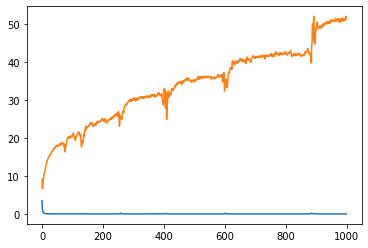

In [38]:


# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(test_loss, color='tab:orange')

plt.show()

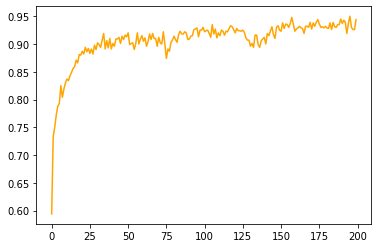

In [45]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(test_accuracy[:200], color='orange')

plt.show()